## InsurTech: Using AI & ML to predict Insurance Health Care Charges

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

import tkinter as tk

In [2]:
# read csv file
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Preprocessing
#### See if there are any null values in the data set

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

## Data Exploration
#### Create categories for age and bmi
##### Create categories to get a better idea of the clients' age and bmi

In [5]:
#separate the array elements (age) into different bins

df_age = df.copy()
age_bins = [13, 20, 30, 40, 50, 60, 120]
age_labels = ['teens', '20s', '30s', '40s', '50s', '60+']
df_age['age_range'] = pd.cut(df_age.age, age_bins, labels = age_labels, include_lowest = True)
df_age

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,teens
1,18,male,33.770,1,no,southeast,1725.55230,teens
2,28,male,33.000,3,no,southeast,4449.46200,20s
3,33,male,22.705,0,no,northwest,21984.47061,30s
4,32,male,28.880,0,no,northwest,3866.85520,30s
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,40s
1334,18,female,31.920,0,no,northeast,2205.98080,teens
1335,18,female,36.850,0,no,southeast,1629.83350,teens
1336,21,female,25.800,0,no,southwest,2007.94500,20s


In [6]:
# separate the array elements (bmi) into different bins

df_groups = df_age.copy()
bmi_bins = [0, 18.5, 24.9, 29.9, 60]
bmi_labels = ['underweight', 'healthy', 'overweight', 'obese']
df_groups['weight_category'] = pd.cut(df_groups.bmi, bmi_bins, labels = bmi_labels, include_lowest = True)
df_groups

,age,sex,bmi,children,smoker,region,charges,age_range,weight_category
0,19,female,27.900,0,yes,southwest,16884.92400,teens,overweight
1,18,male,33.770,1,no,southeast,1725.55230,teens,obese
2,28,male,33.000,3,no,southeast,4449.46200,20s,obese
3,33,male,22.705,0,no,northwest,21984.47061,30s,healthy
4,32,male,28.880,0,no,northwest,3866.85520,30s,overweight
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,40s,obese
1334,18,female,31.920,0,no,northeast,2205.98080,teens,obese
1335,18,female,36.850,0,no,southeast,1629.83350,teens,obese
1336,21,female,25.800,0,no,southwest,2007.94500,20s,overweight


### Graph the categories
##### counts the number of observations per category for a categorical variable, and displays the results as a bar chart

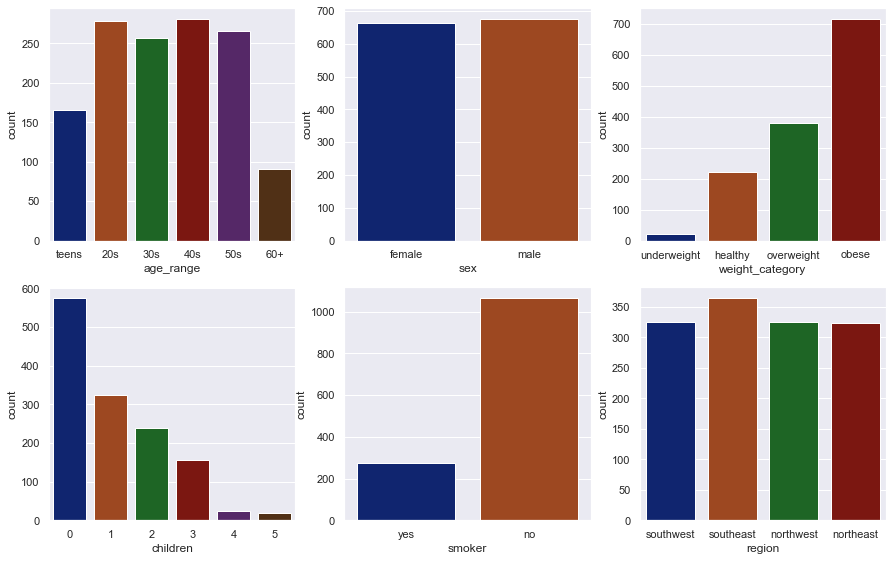

In [7]:
feature = ['age_range', 'sex', 'weight_category', 'children', 'smoker', 'region']
plt.figure(figsize = (15, 30))
for i in enumerate(feature):
    plt.subplot(6, 3, i[0]+1)
    sns.countplot(x = i[1], palette = 'dark', data = df_groups)

## Pie Chart
####  Get the actual percentages of each category so we can input them into a pie chart

In [8]:
w_percent = df_groups['weight_category'].value_counts(normalize = True)
a_percent = df_groups['age_range'].value_counts(normalize = True)
r_percent = df_groups['region'].value_counts(normalize = True)
s_percent = df_groups['smoker'].value_counts(normalize = True)
print(w_percent)
print(a_percent)
print(r_percent)
print(s_percent)

obese          0.535127
overweight     0.284006
healthy        0.165172
underweight    0.015695
Name: weight_category, dtype: float64
40s      0.210015
20s      0.207773
50s      0.198057
30s      0.192078
teens    0.124066
60+      0.068012
Name: age_range, dtype: float64
southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: region, dtype: float64
no     0.795217
yes    0.204783
Name: smoker, dtype: float64


#### Let's assign these values in labels

In [9]:
#labels for weight category
w_labels = ['obese', 'overweight', 'healthy', 'underweight']
w_data = w_percent
w_explode = (0.1, 0, 0, 0)

#labels for age_range
a_labels = ['40s', '20s', '50s', '30s', 'teens', '60+']
a_data = a_percent
a_explode = (0.1, 0, 0, 0, 0 , 0)

#labels for region
r_labels = ['southeast', 'southwest', 'northwest', 'northeast']
r_data = r_percent
r_explode = (0.1, 0, 0, 0)

#labels for smoker 
s_labels = ['no', 'yes']
s_data = s_percent
s_explode = (0.1, 0)

### Now the actual graph

<ipython-input-10-5af28e629d06>:14: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax2.pie(a_data, explode= a_explode, labels=a_labels, autopct='%1.1f%%',
<ipython-input-10-5af28e629d06>:21: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax3.pie(r_data, explode= r_explode, labels=r_labels, autopct='%1.1f%%',


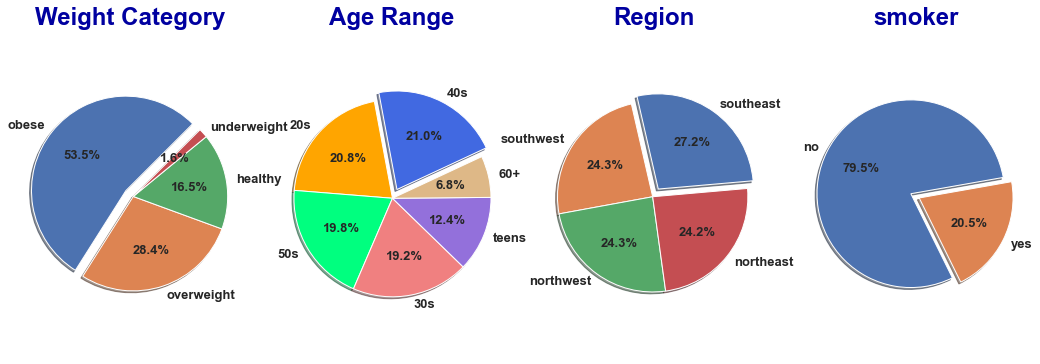

In [10]:
# assign different colors to the second pie chart. because we found it confusing having it all with the same color scheme.
# We use autopct to display the percent value using Python string formatting.

colors = ['royalblue', 'orange', 'springgreen', 'lightcoral', 'mediumpurple', 'burlywood']
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (18,6))

# ax1 for weight category
ax1.pie(w_data, explode=w_explode, labels=w_labels, autopct='%1.1f%%',
        shadow=True, startangle=45, textprops={'fontsize': 13, 'weight': 'bold'})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Weight Category", fontdict = {'fontsize': 24, 'fontweight': 'bold',
                                             'color': '#0000A0'})
# ax2 for Age range
ax2.pie(a_data, explode= a_explode, labels=a_labels, autopct='%1.1f%%',
        shadow=True, startangle=25, textprops={'fontsize': 13, 'weight': 'bold'}, 
        colors = colors)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Age Range", fontdict = {'fontsize': 24, 'fontweight': 'bold',
                                       'color': '#0000A0'})
# ax3 for Region
ax3.pie(r_data, explode= r_explode, labels=r_labels, autopct='%1.1f%%',
        shadow=True, startangle=5, textprops={'fontsize': 13, 'weight': 'bold'})
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.set_title("Region", fontdict = {'fontsize': 24, 'fontweight': 'bold',
                                       'color': '#0000A0'})
#ax4 for smoker
ax4.pie(s_data, explode= s_explode, labels=s_labels, autopct='%1.1f%%',
        shadow=True, startangle=10, textprops={'fontsize': 13, 'weight': 'bold'})
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.set_title("smoker", fontdict = {'fontsize': 24, 'fontweight': 'bold',
                                       'color': '#0000A0'})



plt.show()

## Change the strings into numbers

In [11]:
df['sex'] = df['sex'].apply({'male':0,'female':1}.get) 
df['smoker'] = df['smoker'].apply({'yes':1, 'no':0}.get)
df['region'] = df['region'].apply({'southwest':1, 'southeast':2, 'northwest':3, 'northeast':4}.get)
df

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,1,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,3,21984.47061
4,32,0,28.880,0,0,3,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,3,10600.54830
1334,18,1,31.920,0,0,4,2205.98080
1335,18,1,36.850,0,0,2,1629.83350
1336,21,1,25.800,0,0,1,2007.94500


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
sex,1338.0,0.494768,0.500160,0.0000,0.00000,0.000,1.000000,1.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
smoker,1338.0,0.204783,0.403694,0.0000,0.00000,0.000,0.000000,1.00000
region,1338.0,2.484305,1.104885,1.0000,2.00000,2.000,3.000000,4.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## Correlation

In [ ]:
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap = 'viridis')

<AxesSubplot:>

##### Sex, children, and Region have the lowest correlation to charges.

In [ ]:
# Visulaizing the relationship between the variables
sns.catplot(x="children", y="charges",
            col="region",
            data=df_groups, kind="strip",
            height=4, aspect=.8, palette = "Set2")

##### Region has a very low correlation to charges. We see that the charges are very similar for each region.

### Machine Learning models
##### 1- Store Feature Matrix in X and response(Target) in vector y

In [ ]:
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y = df['charges']

##### 2- Split the data into train and test sets

In [ ]:
# Split the data into 0.20 test, 0.80 train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

##### 3- Model Training 

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
svm = SVR()
svm.fit(X_train, y_train)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
gr = GradientBoostingRegressor()
gr.fit(X_train, y_train)

##### 4-  Prediction on Test Data

In [ ]:
y_pred1 = lr.predict(X_test)
y_pred2 = svm.predict(X_test)
y_pred3 = rf.predict(X_test)
y_pred4 = gr.predict(X_test)

df1 = pd.DataFrame({'Actual':y_test,'Lr':y_pred1,
                  'svm':y_pred2,'rf':y_pred3,'gr':y_pred4})
df1

##### 5- Compare Performance Visually

In [ ]:
plt.subplot(221)
plt.plot(df1['Actual'].iloc[0:3],label='Actual')
plt.plot(df1['Lr'].iloc[0:3],label="Lr")
plt.legend()

plt.subplot(222)
plt.plot(df1['Actual'].iloc[0:3],label='Actual')
plt.plot(df1['svm'].iloc[0:3],label="svr")
plt.legend()

plt.subplot(223)
plt.plot(df1['Actual'].iloc[0:3],label='Actual')
plt.plot(df1['rf'].iloc[0:3],label="rf")
plt.legend()

plt.subplot(224)
plt.plot(df1['Actual'].iloc[0:3],label='Actual')
plt.plot(df1['gr'].iloc[0:3],label="gr")

plt.tight_layout()

plt.legend()

##### 6-  Evaluating the Algorithm

In [ ]:
score1 = metrics.r2_score(y_test,y_pred1)
score2 = metrics.r2_score(y_test,y_pred2)
score3 = metrics.r2_score(y_test,y_pred3)
score4 = metrics.r2_score(y_test,y_pred4)
print(score1,score2,score3,score4)

##### Model 4 (GradientBoostingRegressor) performing the highest accuracy (0.87)

In [ ]:
s1 = metrics.mean_absolute_error(y_test,y_pred1)
s2 = metrics.mean_absolute_error(y_test,y_pred2)
s3 = metrics.mean_absolute_error(y_test,y_pred3)
s4 = metrics.mean_absolute_error(y_test,y_pred4)
print(s1,s2,s3,s4)

##### Model 4 (GradientBoostingRegressor) performing the lowest absolute error (2447)

##### 7- Predict Charges For New Customer

In [ ]:
data = {'age' : 40,
        'sex' : 1,
        'bmi' : 40.30,
        'children' : 4,
        'smoker' : 1,
        'region' : 2}

df = pd.DataFrame(data,index=[0])
df

In [ ]:
new_pred = gr.predict(df)
print("Medical Insurance cost for New Customer is : ",new_pred[0])

##### From above we found that gredianBoostingRegressor is the best model for this dataset. Before production, it is good practice to train our model on the entire dataset.

#### Save Model using joblib

In [ ]:
gr = GradientBoostingRegressor()
gr.fit(X,y)

In [ ]:
import joblib
joblib.dump(gr, 'Model_joblib_gr')
model = joblib.load('Model_joblib_gr')
model.predict(df)

#### Predict charges for new clients by using Graphical User Interface GUI

In [ ]:
from tkinter import *

def show_entry():
    pl = float (el.get())
    p2 = float (e2.get())
    p3 = float (e3.get()) 
    p4 = float (e4.get())
    p5 = float (e5.get())
    p6 = float (e6.get()) 
    model = joblib.load ('model_joblib_gr') 
    result = model.predict ([ [pl,p2,p3,p4,p5,p6]])
    Label (master, text = "Insurance Cost ").grid(row=7)
    Label (master, text =result).grid(row=8)
    
master =Tk()
master.title("Insurance Cost Prediction") 
label = Label (master, text = "Insurance Cost Prediction", bg="black" , fg = "white").grid(row=0,columnspan=2)
Label (master,text = "Enter Your Age").grid(row=1)
Label (master,text = "Male Or Female [1/0]").grid(row=2)
Label (master,text = "Enter Your BMI Value").grid(row=3) 
Label (master,text = "Enter Number of Children").grid(row=4) 
Label (master,text = "Smoker Yes/No [1/0]").grid(row=5) 
Label (master,text = "Region [1_Southwest/2_Southeast/3_Northwest/4_Northeast]").grid(row=6) 
el = Entry (master)
e2 = Entry (master) 
e3 = Entry (master) 
e4 = Entry (master) 
e5 = Entry (master) 
e6 = Entry (master) 
el.grid (row=1,column=1) 
e2.grid (row=2, column=1)
e3.grid (row=3, column=1)
e4.grid (row=4, column=1)
e5.grid (row=5, column=1)
e6.grid (row=6, column=1)
Button(master,text="Predict",command=show_entry).grid()

mainloop()